# Word2vec


## Table of Content
1. Gensim Word2vec&Doc2vec
2. Corpus preprocessing
3. Skip-gram with negative sampling by portch

We will use the corpus [*text8*](http://mattmahoney.net/dc/text8.zip) for word2vec training. You can download it or any text corpus of interest into your google drive folder. Just remember to clean and format your corpus into a list of words sperated by whitespace, e.g.,

```
This is a sample of your text corpus .
```

It is also recommended to request a **GPU** for the training, but most time-consuming operation of word2vec is the batch data preparation, so, this is an example for Skip-gram with negative sampling understanding. You can try to compare with original [word2vec.c](https://github.com/zhaozhiyong19890102/OpenSourceReading/blob/master/word2vec/word2vec.c) using C programming language, which is very fast.

In [ ]:
#@title show your CPU or GPU details
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3997195289758829018
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14343274496
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9453174965900357999
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [ ]:
#@title connect google drive

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SMU_MITB_NLP/week3/

Mounted at /content/drive
/content/drive/MyDrive/SMU_MITB_NLP/week3


## Useful packages

Here we imported all packages we will use today!

[Gensim](https://radimrehurek.com/gensim/) is a fast library for training of vector embeddings. An official tutorial about its word2vec can be find [here](https://radimrehurek.com/gensim/models/word2vec.html). 

[collections](https://docs.python.org/3/library/collections.html) is a very useful preprocessing package, which can count and operate over words efficiently.

[pickle](https://docs.python.org/3/library/pickle.html) implements binary protocols for serializing and de-serializing a Python object structure. Simply speaking, it is to save and store you class instance.

[zipfile](https://docs.python.org/3/library/zipfile.html) is to create, read, write, append, and list a ZIP file, even without extracting the files.

In [2]:
import gensim
import gensim.downloader as api
import collections
import pickle
import zipfile

import torch
import torch.nn as nn
import random
import numpy as np
import math
import os

# below is for visualization
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.decomposition import PCA

# Gensim Word2vec

Load the pre-trained word embeddings ([gensim model list](https://github.com/RaRe-Technologies/gensim-data), e.g., glove-wiki-gigaword-50), please do the following investigation:



1. print the most similar words of a given word, e.g., "great"
2. do word analogy, find out the missing word from "positive"-"negative" = "?" - "sad"
3. find out the word that is most dissimilar with others, e.g., "cereal" from "breakfast cereal dinner lunch"
4. Visualize word vectors by calling the given function *display_pca_scatterplot*. Example words may be:

['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'water',
                         'spaghetti', 'borscht', 'hamburger', 'pizza', 'sushi', 'meatballs',
                         'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
                         'frog', 'monkey', 'ape', 'toad', 'wolf',
                         'france', 'germany', 'hungary', 'luxembourg', 'australia', 'china',
                         'assignment', 'problem', 'exam', 'test', 'class',
                         'school', 'college', 'university', 
                         'scary', 'funny', 'hate', 'love']

The loaded word vectors will be stored efficiently in *keyedvector*, more supported operations can be found [here](https://radimrehurek.com/gensim/models/keyedvectors.html)


In [ ]:
word_vectors = api.load("glove-wiki-gigaword-50")  # load pre-trained word-vectors from gensim-data

[==================================================] 100.0% 66.0/66.0MB downloaded


In [ ]:
# output the most similar words
word_vectors.most_similar('great')

[('greatest', 0.8162122964859009),
 ('good', 0.7982692718505859),
 ('perhaps', 0.7948641180992126),
 ('life', 0.7842895984649658),
 ('well', 0.7827135920524597),
 ('little', 0.7802039384841919),
 ('much', 0.7801195979118347),
 ('inspiration', 0.7777776718139648),
 ('luck', 0.7774538993835449),
 ('experience', 0.771788477897644)]

In [ ]:
# output the most analogy similar words
result = word_vectors.most_similar(positive=['positive', 'sad'], negative=['negative'])
print("{}: {:.4f}".format(*result[0]))

happy: 0.7361


In [ ]:
# output the most dissimilar word
print(word_vectors.doesnt_match("breakfast cereal dinner lunch".split()))

cereal


In [ ]:
#@title Example of word vector
word_vectors.__getitem__('hello')

array([-0.38497 ,  0.80092 ,  0.064106, -0.28355 , -0.026759, -0.34532 ,
       -0.64253 , -0.11729 , -0.33257 ,  0.55243 , -0.087813,  0.9035  ,
        0.47102 ,  0.56657 ,  0.6985  , -0.35229 , -0.86542 ,  0.90573 ,
        0.03576 , -0.071705, -0.12327 ,  0.54923 ,  0.47005 ,  0.35572 ,
        1.2611  , -0.67581 , -0.94983 ,  0.68666 ,  0.3871  , -1.3492  ,
        0.63512 ,  0.46416 , -0.48814 ,  0.83827 , -0.9246  , -0.33722 ,
        0.53741 , -1.0616  , -0.081403, -0.67111 ,  0.30923 , -0.3923  ,
       -0.55002 , -0.68827 ,  0.58049 , -0.11626 ,  0.013139, -0.57654 ,
        0.048833,  0.67204 ], dtype=float32)

In [ ]:
#@title Visualization: get the static images for Matplotlib (do not necessary to understand!)
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(8,8))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.1, y+0.1, word, fontsize=20)

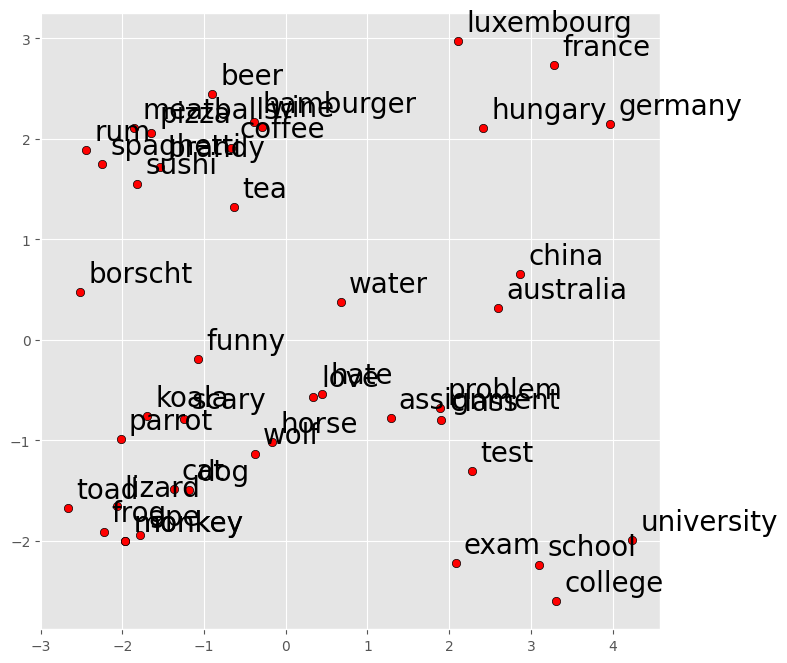

In [ ]:
#@title plot
display_pca_scatterplot(word_vectors, 
                        ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'water',
                         'spaghetti', 'borscht', 'hamburger', 'pizza', 'sushi', 'meatballs',
                         'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
                         'frog', 'monkey', 'ape', 'toad', 'wolf',
                         'france', 'germany', 'hungary', 'luxembourg', 'australia', 'china',
                         'assignment', 'problem', 'exam', 'test', 'class',
                         'school', 'college', 'university', 
                         'scary', 'funny', 'hate', 'love'])

## Gensim Doc2vec

Mostly, you will need to represent a sentence or document with a vector, instead of words. Doc2vec is to learn sentence/document vectors. The basic idea is: act as if a document has another floating word-like vector, which contributes to all training predictions, and is updated like other word-vectors, but we will call it a doc-vector. Below is from the offical [tutorial](https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py).

In [3]:
#@title Prepare the Training and Test Data
# Set file names for train and test data
test_data_dir = os.path.join(gensim.__path__[0], 'test', 'test_data')
lee_train_file = os.path.join(test_data_dir, 'lee_background.cor')
lee_test_file = os.path.join(test_data_dir, 'lee.cor')

In [4]:
#@title function to read and preprocess texts
import smart_open

def read_corpus(fname, tokens_only=False):
    with smart_open.open(fname, encoding="iso-8859-1") as f:
        for i, line in enumerate(f):
            tokens = gensim.utils.simple_preprocess(line)
            if tokens_only:
                yield tokens
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

train_corpus = list(read_corpus(lee_train_file))
test_corpus = list(read_corpus(lee_test_file, tokens_only=True))

In [5]:
print(train_corpus[:2])

[TaggedDocument(words=['hundreds', 'of', 'people', 'have', 'been', 'forced', 'to', 'vacate', 'their', 'homes', 'in', 'the', 'southern', 'highlands', 'of', 'new', 'south', 'wales', 'as', 'strong', 'winds', 'today', 'pushed', 'huge', 'bushfire', 'towards', 'the', 'town', 'of', 'hill', 'top', 'new', 'blaze', 'near', 'goulburn', 'south', 'west', 'of', 'sydney', 'has', 'forced', 'the', 'closure', 'of', 'the', 'hume', 'highway', 'at', 'about', 'pm', 'aedt', 'marked', 'deterioration', 'in', 'the', 'weather', 'as', 'storm', 'cell', 'moved', 'east', 'across', 'the', 'blue', 'mountains', 'forced', 'authorities', 'to', 'make', 'decision', 'to', 'evacuate', 'people', 'from', 'homes', 'in', 'outlying', 'streets', 'at', 'hill', 'top', 'in', 'the', 'new', 'south', 'wales', 'southern', 'highlands', 'an', 'estimated', 'residents', 'have', 'left', 'their', 'homes', 'for', 'nearby', 'mittagong', 'the', 'new', 'south', 'wales', 'rural', 'fire', 'service', 'says', 'the', 'weather', 'conditions', 'which', '

In [6]:
print(test_corpus[:2])

[['the', 'national', 'executive', 'of', 'the', 'strife', 'torn', 'democrats', 'last', 'night', 'appointed', 'little', 'known', 'west', 'australian', 'senator', 'brian', 'greig', 'as', 'interim', 'leader', 'shock', 'move', 'likely', 'to', 'provoke', 'further', 'conflict', 'between', 'the', 'party', 'senators', 'and', 'its', 'organisation', 'in', 'move', 'to', 'reassert', 'control', 'over', 'the', 'party', 'seven', 'senators', 'the', 'national', 'executive', 'last', 'night', 'rejected', 'aden', 'ridgeway', 'bid', 'to', 'become', 'interim', 'leader', 'in', 'favour', 'of', 'senator', 'greig', 'supporter', 'of', 'deposed', 'leader', 'natasha', 'stott', 'despoja', 'and', 'an', 'outspoken', 'gay', 'rights', 'activist'], ['cash', 'strapped', 'financial', 'services', 'group', 'amp', 'has', 'shelved', 'million', 'plan', 'to', 'buy', 'shares', 'back', 'from', 'investors', 'and', 'will', 'raise', 'million', 'in', 'fresh', 'capital', 'after', 'profits', 'crashed', 'in', 'the', 'six', 'months', 'to'

In [7]:
#@title Prepare for training!
# init model
doc_model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
# build vocab
doc_model.build_vocab(train_corpus)
print(f"Word 'penalty' appeared {doc_model.wv.get_vecattr('penalty', 'count')} times in the training corpus.")

Word 'penalty' appeared 4 times in the training corpus.


In [8]:
#@title training!
doc_model.train(train_corpus, total_examples=doc_model.corpus_count, epochs=doc_model.epochs)

In [9]:
#@title Inferring
sent1 = ['a', 'book', 'is', 'a', 'ladder', 'of', 'human', 'progress']
vec1 = doc_model.infer_vector(sent1)
print(vec1)

[-0.5292058  -0.06360625 -0.23885787 -0.22811002 -0.23963374  0.04295122
  0.12571461  0.02415713 -0.14938731  0.04006434  0.0823302  -0.2382913
 -0.133784    0.02999185 -0.2599221   0.09465017  0.3297627   0.22867388
 -0.10396282 -0.13096988  0.0762272   0.06207587  0.4276916  -0.02306016
  0.28667134  0.23037738 -0.18418145  0.09023972 -0.28169385 -0.23865491
  0.15888889  0.12737651 -0.17898557  0.40175524  0.10424179  0.15855466
  0.14046554  0.03615128  0.21761352  0.06498952  0.00099735  0.04770656
 -0.16823177 -0.1514129   0.45231545  0.24790147  0.13361764 -0.19712493
  0.34275654 -0.0274359 ]


In [10]:
sent2 = ['books', 'are', 'the', 'means', 'to', 'our', 'growth']
sims = doc_model.similarity_unseen_docs(sent1, sent2)
print(sims)

0.43788376


## Corpus preprocessing

In class, we have introduced tokenization, which is one step of corpus preprocessing. We will use a simple tokenization method --- splitting by whitespace!

In facts, there are many other steps and techniques for corpus preprocessing, such as normalization covered in additional slides. Also, we have to deal with encoding issues, build the vocabulary, replace words with vocab index, etc.

## Read data from file and tokenization


Read text from file, the format is a **single** line of word sequence separated by whitespace:

```
This is a sample of your text corpus .
```

You will need:

1. convert all words into lower-case
2. tokenize it into a list of words: [w1, w2, ...]

In [ ]:
# set up your own path to text corpus
data_path = './text8.zip'

with zipfile.ZipFile(data_path) as f:
    text_words = f.read(f.namelist()[0])

# do not change the code above
# write your code here

# do not change the code below

print("total number of tokens: {}.".format(len(text_words)))
print(text_words[:10])

total number of tokens: 17005207.
[b'anarchism', b'originated', b'as', b'a', b'term', b'of', b'abuse', b'first', b'used', b'against']


In [ ]:
#@title decoding bytes object (e.g., b'as') to utf8 encoding
clean_words = []
for w in text_words:
    clean_words.append(w.decode('utf8'))
print(clean_words[:10])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


### Class PreProcessor

For each NLP project, we usually create one or multiple classes for corpus preprocessing. It initalizes the hyperparameters, build vocabulary, convert input texts into features, generate batched data, serializing and de-serializing them, etc.

Here is a good example. You will need to understand the class, and complete the function *convert_texts_to_features*. It takes the tokenized corpus as inputs, and:

1. count each word frequency in the corpus
2. build vocabulary *w2id_vocab*, *id2w_vocab*, and *count_vocab*, note that 1) a special token 'UNK' should be added as 0-index for out-of-vocabulary word, 2) the vocabulary size should be smaller than the pre-defined *max_vocabulary_size*, and 3) the minimum count of words in your vocabulary should be larger than the pre-defined *min_occurrence*. Example:

```
w2id_vocab = {'UNK':0, 'a':1, ...}  key denotes the word, value denotes the index in your vocabulary, a.k.a. id.

id2w_vocab = {0:'UNK', 1:'a', ...} key denotes the id, value denotes the word.

count_vocab - {0:10000, 1:2000, ...} key denotes the id, value denotes the counts.
```

3. replace each word in inputs with its corresponding id. For word not included in your vocabulary, use id 0 (i.e., 'UNK') instead.
4. return the list of word ids as *data*.


*get_batch* function uses the tricks for word2vec training. You may read it :)

In [ ]:
#@title class for preparing data for neural network
class PreProcessor():

    def __init__(self):
        
        self.model_args = {
            'max_vocabulary_size': 50000,
            'min_occurrence': 10,  # Remove all words that does not appears at least n times.
            'num_negatives': 25,
            'window_size': 3,
            'sample_t': 0.00001,
            'neg_alpha': 0.75,
            # Training Parameters.
            'emb_size': 50,
            'learning_rate': 0.1,
            'batch_size': 128,
            'num_steps': 50
        }

        self.w2id_vocab = {}
        self.id2w_vocab = {}
        self.count_vocab = {}
        self.neg_probs = {}
        self.sub_probs = {}

        self.pretrained_emb = None
        self.vocab_size = len(self.w2id_vocab)
        self.data_index = 0

    def save(self, path):
        f = open(path, 'wb')
        pickle.dump(self, f)
        f.close()

    def load(self, path):
        f = open(path, 'rb')
        proc = pickle.load(f)
        f.close()
        return proc
    
    def set_model_arg(self, key, value):
        self.model_args[key] = value
    
    def get_model_arg(self, key):
        return self.model_args.get(key, None)
    
    def get_vocab_size(self):
        self.vocab_size = len(self.w2id_vocab)
        return self.vocab_size

    def words2ids(self, words):
        word_ids = list()
        for w in words:
            wid = self.w2id_vocab.get(w, 0)
            word_ids.append(wid)
        return word_ids
    
    def id2words(self, word_ids):
        words = list()
        for wid in word_ids:
            w = self.id2w_vocab.get(wid, self.id2w_vocab[0])
            words.append(w)
        return words
    
    def convert_texts_to_features(self, words):
        # Build the dictionary and replace words with their ids for outputs data.
        # do not change the code above
        # write your code here

        # do not change the code below

        return data

    def count_sampling_probs(self):
        # build negtive sampling and sub sampling probs
        total_num = sum([c for c in self.count_vocab.values()])
        total_weight_num = sum([pow(c, self.get_model_arg('neg_alpha')) for c in self.count_vocab.values()])
        for w, c in self.count_vocab.items():
            self.neg_probs[w] = self.get_neg_prob(c, total_weight_num)
            self.sub_probs[w] = self.get_sub_prob(c, total_num)
    
    def load_pretrained_model(self, model):
        self.pretrained_emb = []
        vec_size = len(word_vectors.__getitem__('hello'))
        for id, w in self.id2w_vocab.items():
            vec = model.__getitem__(w) if model.__contains__(w) else np.zeros(vec_size)
            self.pretrained_emb.append(vec)
        self.pretrained_emb = torch.FloatTensor( np.array(self.pretrained_emb) )

    def get_neg_prob(self, count, total):
        return pow(count, self.get_model_arg('neg_alpha'))/total

    def get_sub_prob(self, count, total):
        inverse_prob = self.get_model_arg('sample_t')*total/count
        return (math.sqrt(1/inverse_prob) + 1) * inverse_prob
    
    def get_batch(self, data):

        batch_size = self.get_model_arg('batch_size')
        window_size = self.get_model_arg('window_size')

        batch_count = 0
        batch = []
        pos_label = []
        neg_label = []

        while True:
            tmp_window = random.randint(1, window_size)
            # get window size (words left and right + current one).
            span = 2 * tmp_window + 1
            if self.data_index + span >= len(data):
                self.data_index = 0
            text_span = data[self.data_index:self.data_index + span]
            self.data_index += 1

            if batch_count == 0 :
                batch = []
                pos_label = []
                neg_label = []
                batch_count = 0

            current_word = text_span[tmp_window]
            for i, w in enumerate(text_span):
              if i == tmp_window: continue
              # skip frequent words by subsampling
              sub_prob = self.sub_probs[w]
              if random.random() > sub_prob : continue
              batch.append(current_word)
              pos_label.append(w)
              # negative sampling
              neg_label.append( np.random.choice(list(self.neg_probs.keys()), size=self.get_model_arg('num_negatives'), p=list(self.neg_probs.values()), replace=True) )
              batch_count += 1
              if batch_count == self.get_model_arg('batch_size'):
                  res_batch = batch
                  res_pos = pos_label
                  res_neg = neg_label

                  batch_count = 0
                  batch = []
                  pos_label = []
                  neg_label = []
                  yield torch.LongTensor( np.array(res_batch) ), torch.LongTensor(np.array(res_pos)), torch.LongTensor(np.array(res_neg))

In [ ]:
# preprare dataset and hyper-parameters for training
proc = PreProcessor()

data = proc.convert_texts_to_features(clean_words)
proc.count_sampling_probs()
# if you want to train from scratch, need to comment the below line out
proc.load_pretrained_model(word_vectors)      

# arguments for reproduction
proc.set_model_arg('init_seed', 42)
proc.set_model_arg('log_step', 10)
proc.set_model_arg('checkpoint_path', "./word2vec.bin")

# save proc
arg_path = "./proc.dat"
proc.save(arg_path)

Words count: 17005207
Unique words: 253854
Vocabulary size: 47135


In [ ]:
proc.id2words(data[:20])

['anarchism',
 'originated',
 'as',
 'a',
 'term',
 'of',
 'abuse',
 'first',
 'used',
 'against',
 'early',
 'working',
 'class',
 'radicals',
 'including',
 'the',
 'diggers',
 'of',
 'the',
 'english']

In [ ]:
data_iter = proc.get_batch(data)
center_words, pos_words, neg_words = next(data_iter)
print(proc.id2words(center_words.numpy()[:5]))
print(proc.id2words(pos_words.numpy()[:5]))
print(proc.id2words(neg_words.numpy()[0][:5]))    # note that this is just one dimension of neg_words

['as', 'as', 'as', 'term', 'term']
['anarchism', 'originated', 'term', 'originated', 'abuse']
['s', 'unbiased', 'ph', 'demolition', 'staging']


In [ ]:
proc.pretrained_emb

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.4180,  0.2497, -0.4124,  ..., -0.1841, -0.1151, -0.7858],
        [ 0.7085,  0.5709, -0.4716,  ..., -0.2256, -0.0939, -0.8037],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.3776,  0.1681, -0.0512,  ...,  0.1886,  0.1667,  0.0521],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

##Skip-gram with negative sampling by portch

Details about the model can be found in our slides. You will need to complete the class *SkipgramNegSampling* for skip-gram training:

1. initialize two nn.Embedding for input embedding (i.e., *embedding_i*) and output embedding (i.e., *embedding_o*), respectively.
2. complete *forward* function same with our slides P58

In [ ]:
#@title vanilla skipgram
class SkipgramNegSampling(nn.Module):
    
    def __init__(self, vocab_size, embed_dim, pretrained_emb=None):
        super(SkipgramNegSampling, self).__init__()
        
        # do not change the code above
        # write your code here

        # do not change the code below

        nn.init.xavier_normal_(self.embedding_i.weight)
        nn.init.xavier_normal_(self.embedding_o.weight)

        self.logsigmoid = nn.LogSigmoid()
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        
    def forward(self, center_words, pos_words, neg_words):
        # example center_words, pos_words, and neg_words can be found above
        # do not change the code above
        # write your code here

        # do not change the code below
        return loss
    
    def similarity(self, inputs, targets):
        input_embeds = self.embedding_i(inputs) # B x D
        target_embeds = self.embedding_i(targets) # B x D
        sim_score = self.cos(input_embeds, target_embeds) # Bx1
        return sim_score

### Training preparation

In [ ]:
#@title utility functions
# some of the codes are revised from https://github.com/312shan/Pytorch-seq2seq-Beam-Search/blob/master/model.py

def check_gpu():
    # torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
    is_cuda = torch.cuda.is_available()

    # If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
    if is_cuda:
        device = torch.device("cuda")
        print("GPU is available")
    else:
        device = torch.device("cpu")
        print("GPU not available, CPU used")
    return device

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def save_model(model, path):
    torch.save(model.state_dict(), path)

def load_model(model, path):
    model.load_state_dict(torch.load(path))
    return model

In [ ]:
#@title training function

def train(model, proc, data, device):
    # fetch hyper-parameters
    batch_size = proc.get_model_arg("batch_size")
    num_steps = proc.get_model_arg('num_steps')
    learning_rate = proc.get_model_arg("learning_rate")
    checkpoint_path = proc.get_model_arg("checkpoint_path")
    log_step = proc.get_model_arg("log_step")
    
    data_iter = proc.get_batch(data)
    # Define Loss, Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    # train!
    
    for step in range(num_steps):
        model.train()
        optimizer.zero_grad() # Clears existing gradients from previous epoch
        # prepare inputs
        word, pos, neg = next(data_iter)

        loss = model(word.to(device), pos.to(device), neg.to(device))

        loss.backward() # Does backpropagation and calculates gradients
        # clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step() # Updates the weights accordingly
        if step % 10000 == 0:
            scheduler.step()
            
        if step % log_step == 0:
            print("\rstep: {}/{}, Loss: {:.4f}, saving model to {}".format(step, num_steps, loss.item(), proc.get_model_arg('checkpoint_path')), end=' ')

### Training!

In [ ]:
# get parameters from preprocessor
init_seed = proc.get_model_arg('init_seed')

device = check_gpu()
set_seed(init_seed)

# Instantiate the model with hyperparameters
model = SkipgramNegSampling(vocab_size=proc.get_vocab_size(), embed_dim=proc.get_model_arg('emb_size'), pretrained_emb=proc.pretrained_emb)
# We'll also set the model to the device that we defined earlier (default is CPU)
model = model.to(device)

train(model, proc, data, device)

GPU is available
step: 40/50, Loss: 1.4600, saving model to ./word2vec.bin 

### Testing!

In [ ]:
model.eval()

inputs = proc.words2ids(['good', 'bad'])
targets = proc.words2ids(['great', 'tiger'])

sim_scores = model.similarity(torch.LongTensor(inputs).to(device), torch.LongTensor(targets).to(device))
print(sim_scores.detach().cpu().numpy())

[0.7982692  0.37923753]
